In [96]:
import xml.etree.ElementTree as ET
import pandas as pd
%matplotlib inline


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# create element tree object 
tree = ET.parse('./export.xml') 

# for every health record, extract the attributes into a dictionary (columns). Then create a list (rows).
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

# create DataFrame from a list (rows) of dictionaries (columns)
data = pd.DataFrame(record_list)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    data[col] = pd.to_datetime(data[col])

# value is numeric, NaN if fails
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
data['value'] = data['value'].fillna(1.0)

# shorter observation names: use vectorized replace function
data['type'] = data['type'].str.replace('HKQuantityTypeIdentifier', '')
data['type'] = data['type'].str.replace('HKCategoryTypeIdentifier', '')

In [97]:
pivot_df = data.pivot_table(index='endDate', columns='type', values='value')
df = pivot_df.resample('5min').mean()

In [98]:
ml_df = pd.merge_asof(
    df[df.columns[15:17]].dropna(),
    df['BloodGlucose'].dropna(),
    left_index=True,
    right_index=True,
    direction="nearest",
)


In [99]:
ml_df

HeartRate  HeartRateVariabilitySDNN  BloodGlucose
endDate                                                                     
2021-12-20 11:20:00+02:00  59.258198                   58.3717           5.7
2021-12-20 14:15:00+02:00  71.536346                   80.7055           5.7
2021-12-20 14:55:00+02:00  51.331150                   67.4926           5.7
2021-12-20 15:00:00+02:00  49.814300                   67.1677           5.7
2021-12-20 15:45:00+02:00  62.452567                   89.7570           5.7
...                              ...                       ...           ...
2022-03-18 08:40:00+02:00  59.581467                   38.0936           2.7
2022-03-18 11:40:00+02:00  85.566000                   92.8729           2.7
2022-03-18 13:10:00+02:00  80.000000                   99.3812           2.7
2022-03-18 15:25:00+02:00  64.785700                   79.9148           2.7
2022-03-18 16:35:00+02:00  65.855500                   59.0387           2.7

[557 rows x 3 columns]

In [100]:
len(ml_df[ml_df["BloodGlucose"]<4])


48

In [101]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

x=ml_df[ml_df.columns[0:3]]
x_scaled = scaler.fit_transform(ml_df[ml_df.columns[0:2]])
print(x_scaled)
isolation_forest_model = IsolationForest(contamination="auto", max_features=2, max_samples="auto",n_jobs=-1,random_state=1,verbose=2,warm_start=False, bootstrap=True)
y_hat = isolation_forest_model.fit(x_scaled)  # fit 100 trees  

[[-4.12056595e-01  1.18461232e-03]
 [ 2.41446554e-01  6.86596388e-01]
 [-8.33972919e-01  2.81099909e-01]
 ...
 [ 6.91923654e-01  1.25974313e+00]
 [-1.17855888e-01  6.62330249e-01]
 [-6.09158940e-02  2.16544676e-02]]
Building estimator 1 of 13 for this parallel run (total 100)...Building estimator 1 of 13 for this parallel run (total 100)...Building estimator 1 of 13 for this parallel run (total 100)...Building estimator 1 of 13 for this parallel run (total 100)...Building estimator 1 of 12 for this parallel run (total 100)...Building estimator 1 of 12 for this parallel run (total 100)...Building estimator 1 of 12 for this parallel run (total 100)...Building estimator 1 of 12 for this parallel run (total 100)...







Building estimator 2 of 13 for this parallel run (total 100)...Building estimator 2 of 12 for this parallel run (total 100)...Building estimator 2 of 12 for this parallel run (total 100)...


Building estimator 2 of 13 for this parallel run (total 100)...Building estimato

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


In [102]:
y_pred = isolation_forest_model.predict(x_scaled)
y_scores = isolation_forest_model.decision_function(x_scaled)
outliers_index = np.where(y_scores< -0.05)[0]
df_inliers = x[~x.index.isin(outliers_index)]
df_outlier = x[x.index.isin(outliers_index)]

In [103]:
ml_df.iloc[np.where(y_scores< 0.05)[0]]

HeartRate  HeartRateVariabilitySDNN  BloodGlucose
endDate                                                                      
2021-12-20 14:55:00+02:00   51.331150                   67.4926           5.7
2021-12-20 15:00:00+02:00   49.814300                   67.1677           5.7
2021-12-20 15:45:00+02:00   62.452567                   89.7570           5.7
2021-12-20 18:25:00+02:00  121.008761                   15.1997           5.7
2021-12-20 19:55:00+02:00  101.298667                   24.1745           5.7
...                               ...                       ...           ...
2022-03-17 13:05:00+02:00   59.313000                   91.8599           2.7
2022-03-17 21:50:00+02:00  119.035000                   12.4700           2.7
2022-03-18 08:40:00+02:00   59.581467                   38.0936           2.7
2022-03-18 11:40:00+02:00   85.566000                   92.8729           2.7
2022-03-18 13:10:00+02:00   80.000000                   99.3812           2.7

[364 rows x 3 columns]

In [104]:
ml_df[ml_df["BloodGlucose"].between(0,4)]

HeartRate  HeartRateVariabilitySDNN  BloodGlucose
endDate                                                                      
2021-12-20 22:35:00+02:00   71.000000                  81.73340       3.10000
2021-12-25 01:30:00+02:00   46.558300                  61.79600       2.94190
2021-12-25 03:30:00+02:00   46.154850                  47.82130       2.83088
2021-12-25 05:30:00+02:00   45.256350                  62.30370       2.27581
2021-12-26 07:30:00+02:00   44.442850                  39.49680       3.49697
2021-12-27 05:30:00+02:00   41.926450                  86.00940       3.21943
2021-12-27 07:30:00+02:00   46.889450                 142.50400       3.94103
2021-12-27 08:45:00+02:00   58.689700                  83.12720       3.49697
2021-12-27 11:55:00+02:00   80.209400                  51.52060       3.88552
2021-12-28 15:40:00+02:00   58.637800                  33.02840       2.99740
2021-12-28 16:35:00+02:00   59.216100                 100.86500       3.05291
2022-02-21 21:00:00+02:00   57.084167                  36.07980       3.77451
2022-02-23 22:30:00+02:00   57.631850                  26.16060       3.77451
2022-02-27 13:55:00+02:00   67.260133                 102.47200       3.83002
2022-03-08 15:05:00+02:00   74.497833                  48.29730       2.70000
2022-03-11 09:45:00+02:00   77.522767                  99.08960       2.70000
2022-03-11 11:55:00+02:00   83.706300                  69.22290       2.70000
2022-03-11 14:40:00+02:00   89.851150                  51.17310       2.70000
2022-03-11 15:35:00+02:00   73.046333                  69.78540       2.70000
2022-03-11 17:55:00+02:00   64.101450                 147.78200       2.70000
2022-03-11 19:00:00+02:00   86.522100                  23.20760       2.70000
2022-03-13 17:25:00+02:00   96.229117                  22.67640       2.70000
2022-03-13 21:25:00+02:00   72.000000                  46.51480       2.70000
2022-03-14 08:55:00+02:00   58.156700                  47.10360       2.70000
2022-03-14 11:45:00+02:00   83.934400                  42.28700       2.70000
2022-03-14 13:05:00+02:00   80.630500                  45.88440       2.70000
2022-03-14 17:10:00+02:00   72.449050                  55.54280       2.70000
2022-03-14 18:00:00+02:00   60.604950                  63.52070       2.70000
2022-03-15 13:10:00+02:00   61.233875                  49.24680       2.70000
2022-03-15 13:15:00+02:00   65.542350                  96.19220       2.70000
2022-03-15 15:20:00+02:00   70.137000                  79.50830       2.70000
2022-03-15 18:10:00+02:00   66.493500                  97.50610       2.70000
2022-03-15 19:45:00+02:00   64.042350                  80.16080       2.70000
2022-03-16 08:45:00+02:00   67.291500                  58.02150       2.70000
2022-03-16 10:00:00+02:00   75.806600                  85.31230       2.70000
2022-03-16 11:50:00+02:00   70.426500                  77.43380       2.70000
2022-03-16 16:35:00+02:00   77.467200                  60.10670       2.70000
2022-03-16 19:25:00+02:00   79.126130                 153.83300       2.70000
2022-03-16 22:05:00+02:00   85.000000                  28.45390       2.70000
2022-03-16 23:05:00+02:00   80.975100                  83.75625       2.70000
2022-03-17 13:05:00+02:00   59.313000                  91.85990       2.70000
2022-03-17 17:45:00+02:00   62.346950                  86.77810       2.70000
2022-03-17 21:50:00+02:00  119.035000                  12.47000       2.70000
2022-03-18 08:40:00+02:00   59.581467                  38.09360       2.70000
2022-03-18 11:40:00+02:00   85.566000                  92.87290       2.70000
2022-03-18 13:10:00+02:00   80.000000                  99.38120       2.70000
2022-03-18 15:25:00+02:00   64.785700                  79.91480       2.70000
2022-03-18 16:35:00+02:00   65.855500                  59.03870       2.70000

In [105]:
# ml_df[ml_df["BloodGlucose"].between(0,4)]
x_hat =x.values
idx = np.where(ml_df["BloodGlucose"].between(0.0,4.0))[0]
print(np.intersect1d(idx, outliers_index))
print(idx)
print(outliers_index)

[ 65  77  86  87 452 528 530 546 551 553]
[ 12  63  64  65  77  86  87  88  89  98  99 440 452 476 523 524 525 526
 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544
 545 546 547 548 549 550 551 552 553 554 555 556]
[  6   7   8  15  16  19  21  22  40  47  48  49  50  55  65  66  68  76
  77  86  87  92  95 101 117 133 135 145 148 155 178 194 206 214 273 278
 292 300 307 325 346 352 371 372 396 411 436 437 452 465 469 497 508 509
 511 515 518 519 522 528 530 546 551 553]


In [106]:
print(len(outliers_index))
for i in np.intersect1d(idx, outliers_index):
    print(x_hat[i])

64
[45.25635 62.3037   2.27581]
[44.44285 39.4968   3.49697]
[41.92645 86.0094   3.21943]
[ 46.88945 142.504     3.94103]
[57.63185 26.1606   3.77451]
[ 64.10145 147.782     2.7    ]
[96.22911667 22.6764      2.7       ]
[ 79.12613 153.833     2.7    ]
[119.035  12.47    2.7  ]
[85.566  92.8729  2.7   ]


HeartRate  HeartRateVariabilitySDNN  BloodGlucose
endDate                                                                     
2021-12-20 11:20:00+02:00  59.258198                   58.3717           5.7
2021-12-20 14:15:00+02:00  71.536346                   80.7055           5.7
2021-12-20 14:55:00+02:00  51.331150                   67.4926           5.7
2021-12-20 15:00:00+02:00  49.814300                   67.1677           5.7
2021-12-20 15:45:00+02:00  62.452567                   89.7570           5.7
...                              ...                       ...           ...
2022-03-18 08:40:00+02:00  59.581467                   38.0936           2.7
2022-03-18 11:40:00+02:00  85.566000                   92.8729           2.7
2022-03-18 13:10:00+02:00  80.000000                   99.3812           2.7
2022-03-18 15:25:00+02:00  64.785700                   79.9148           2.7
2022-03-18 16:35:00+02:00  65.855500                   59.0387           2.7

[557 rows x 3 columns]

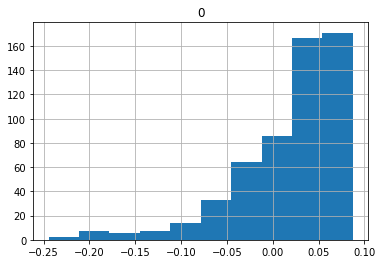

In [107]:
pd.DataFrame(y_scores).hist()
ml_df

In [108]:

ml_df.iloc[np.where(y_scores< -0.5)[0]]

Empty DataFrame
Columns: [HeartRate, HeartRateVariabilitySDNN, BloodGlucose]
Index: []

In [109]:
isolation_forest_model.n_features_in_

2

In [ ]:
# import numpy as np
# import rrcf

# forest = []

# num_outliers = 48

# # Specify forest parameters
# num_trees = 100
# tree_size = 512
# n = 557
# sample_size_range = (n // tree_size, tree_size)

# while len(forest) < num_trees:
#     # Select random subsets of points uniformly from point set
#     ixs = np.random.choice(n, size=sample_size_range,
#                            replace=False)
#     # Add sampled trees to forest
#     trees = [rrcf.RCTree(x_scaled[ix], index_labels=ix)
#              for ix in ixs]
#     forest.extend(trees)


# avg_codisp = pd.Series(0.0, index=np.arange(n))
# index = np.zeros(n)
# for tree in forest:
#     codisp = pd.Series({leaf : tree.codisp(leaf)
#                         for leaf in tree.leaves})
#     avg_codisp[codisp.index] += codisp
#     np.add.at(index, codisp.index.values, 1)
# avg_codisp /= index


In [ ]:
# avg_codisp[:-10].mean()

In [ ]:
# avg_codisp[-10:].mean()

In [ ]:

# print(len([ idx  for idx in range(len(x_scaled))  if avg_codisp[idx] > 8.44]))
    

In [ ]:
# avg_codisp > avg_codisp.quantile(0.99)

In [ ]:
# for i in range(len(avg_codisp)):
#     if avg_codisp[i] > avg_codisp.quantile(0.99):
#         print(i)

In [ ]:
# idx = np.where(ml_df["BloodGlucose"].between(0,4))[0]
# list_y = []
# for i in range(len(ml_df["BloodGlucose"])):
#     if i in idx:
#         list_y.append(1)
#     else:
#         list_y.append(0)
        
    

In [ ]:
# IsolationForest().get_params().keys()